In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle

OMNIGLOT_DATA = os.path.join(os.getcwd(), 'omniglot/')
DATASET_DIR = os.path.join(os.getcwd(), 'cluttered_omniglot/')

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 12.0)

import dataset_utils

from joblib import Parallel, delayed

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create config file

In [3]:
config = dataset_utils.DatasetGeneratorConfig()

### Load Omniglot Dataset

In [4]:
def reorder_chars(chars):
    reordered_chars=[]
    for alph in range(len(chars)):
        for char in range(len(chars[alph])):
            reordered_chars.append(chars[alph][char])
    
    return reordered_chars

#Load chars from pickle file
path = OMNIGLOT_DATA

#Train split
with open(path + 'chars_train.pickle', 'rb') as fp:
    chars_train = pickle.load(fp)
    chars_train = reorder_chars(chars_train)
    
#Evaluation split
with open(path + 'chars_eval.pickle', 'rb') as fp:
    chars_eval = pickle.load(fp)
    chars_eval = reorder_chars(chars_eval)
    
#Test split
with open(path + 'chars_test.pickle', 'rb') as fp:
    chars_test = pickle.load(fp)
    chars_test = reorder_chars(chars_test)

### Dataset Generation Script

In [5]:
checksums = {4: [b'\x8c\x99\x9e\\J\x9a\x811g.eB\xa0\xb3\xf2f', 
              b';\xf8\x05\xb2vk#!\xf9\xad\xb9\x88\xd1\n\x0f\xba', 
              b'\xc6\x84\xf4\x99\x18<cx\x82\xeb\xed*\xbb\xca\x12\x8b', 
              b'\xd3\x8c\x88\rM\xdfSpK\xa7\xf2f\n?\x0e\xad'], 
             8: [b'\x0cY\x0f\xf4#\x872:2\xe1\x12R\xcf\x95rh', 
              b'\x92\x7f\xa3>@\x0cl\xaa\x96\xd7\xad\xbaOj\xdd\xac', 
              b'\xb9m\xc0\xbdN8\xf2\x0fkk\x8c&N\x88\xe2\xb0', 
              b'M\xf1\x8d\r\xe6\xf5\xba\tR\xe3\xcc\xd2\x91\xf2\x96\x81'], 
             16: [b'2}\x08\xf3\xe1\xb1\xb1\xb5\xed\x89\x05\xf1c\xedy^', 
              b'\x8bs>\x95\xa8n9Nw\xf0E\x83\xf8~+\xf2', 
              b'\xde8\xa6\x04\xdfq<\xf0\x05&a\x00EB\xc9B', 
              b'\xbf\x87uy\xec\x90\xbf \x9a\x96x\x9e\xd9w\xd3\x94'], 
             32: [b'\x813\x89v\xc8\xbd\xc16\x8dN\xc5Z\x9eS=y', 
              b'o\xd4\xe0a\x8a\x80\x0f\xba2_\x06\xffE\xed\xf9n', 
              b':\x05\xe2\x03\xfb\x85\x84\x18\xc5\x18\x81d\xd9V\xb9[', 
              b'\xcc\x96\xe1D\x90\xba\xed\xa3\xff\x1c\xd7\xd7\xdf\xe4\xd0A'], 
             64: [b'\x11\x19HZ\x05-\xf3A\xe8\xe6\x0f\x9f\x14\n\xcb\x17', 
              b'VP\x0c\xcf\xa0\xef\x07_\x85[\xa7\x0cL*|\xa2', 
              b'(\x0f\xba,\x0c\x98+\x85\xa9n\xd0a\x1b\xe0p\x03', 
              b'W\xf4\xc7\xed\x19f\xc50f\xb3\xb3\xc8\x80\xf0\xda\x90'], 
             128: [b'\x8a\x11O\x805\xb6\xcf\xf0L\xaf\xad\x93\xbf&/\xb2', 
              b'\xc8\xd16\xfa\xb2\x16h\xd8\xa3h\xf5\x8e\xa7\x00\x90v', 
              b'\x05\xd2\xd94T\xe1\xbb\xb63\x90\x9eX\xd8\t\xfc\xb9', 
              b'el\x85\xda\xfcw\xce\xe0\xf5\x9c\xb7 v\xc6J='], 
             256: [b's\xffZO\xc1j\x87\x7f\xbf\x1fj\xf2]\xc9\x9f\x14', 
              b'D\xbe\x0eZ%\xb2\x16Z\xea\x18S\x1d!6\xd0w', 
              b'\xfbZ\xe4$\x06\xd88J\x99\xfa\x0b*\x92\xdd\xa3\xa8', 
              b'z\xee@d\x0f}\xe8\xd3\xf3\xad\xf7\xe8\xc9]\xfbb']}

In [6]:
# Generate indicidual datasets for each clutter level
# nname =  [4, 8, 16, 32, 64, 128, 256]
# nchars = [3, 7, 15, 31, 63, 127, 255]
nname =  [4]
nchars = [3]

for i in range(len(nname)):
    # Set and print saving directory
    dset_dir = DATASET_DIR + '{}_characters/'.format(nname[i])
    print('')
    print(dset_dir)

    # Set number of images per parallel job
    # config.JOBLENGTH = 2000
    config.JOBLENGTH = 1
    # Set number of distractors
    config.DISTRACTORS = nchars[i]
    
    ### Generate training set ###
    
    # Set dataset split
    config.DRAWER_SPLIT = 'train'
    config.set_drawer_split()
    # Define number of train images
    # dataset_size = 2000000
    dataset_size = 2
    # Choose training alphabets
    chars = chars_train
    # Set path
    path = dset_dir + 'train/'
    # Set a fixed seed
    seed_train = 2209944264

    # Generate dataset
    print('Generating dataset train/')
    dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=seed_train, save=True)
    print('')


    ### Generate evaluation and test sets ###

    # Set dataset split
    config.DRAWER_SPLIT = 'val'
    config.set_drawer_split()
    # Define number of val/test images
    # dataset_size = 10000
    dataset_size = 2

    #Generate evaluation set on train characters
    seed_val_train = 4020197800
    chars = chars_train
    path = dset_dir + 'val-train/'
    print('Generating dataset val-train/')
    dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=seed_val_train, save=True, checksum=checksums[nname[i]][0])
    print('')
    
    #Generate test set on train characters
    seed_test_train = 1665765955
    chars = chars_train
    path = dset_dir + 'test-train/'
    print('Generating dataset test-train/')
    dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=seed_test_train, save=True, checksum=checksums[nname[i]][1])
    print('')

    #Generate evaluation set on one-shot characters
    seed_val_one_shot = 3755213170
    chars = chars_eval
    path = dset_dir + 'val-one-shot/'
    print('Generating dataset val-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=seed_val_one_shot, save=True, checksum=checksums[nname[i]][2])
    print('')

    #Generate test set on one-shot characters
    seed_test_one_shot = 2301871561
    chars = chars_test
    path = dset_dir + 'test-one-shot/'
    print('Generating dataset test-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=seed_test_one_shot, save=True, checksum=checksums[nname[i]][3])
    print('')

print('')
print('All Done')


/home/laielli/cluttered-omniglot/cluttered_omniglot/4_characters/
Generating dataset train/
Executing 2 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.8s finished
Duration: 5.79384183883667
Hash: b'/\x0c\xfd\xa5\xc4\xae\xb1\xa6\x1eK\x1d\x08O\xd9\x05\xb3'

Generating dataset val-train/
Executing 2 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.2s finished
Duration: 4.155951738357544
Hash: b'\x8b:\x0b\xdc\xbe\xa1\x90R1\x80\xe7Z\xb3!\xb8\x1c'
Incorrect hash value!

Generating dataset test-train/
Exe

### Dataset Visualization Script

Executing 2 tasks
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    4.4s finished


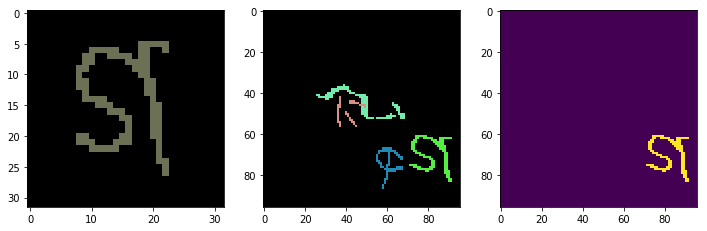

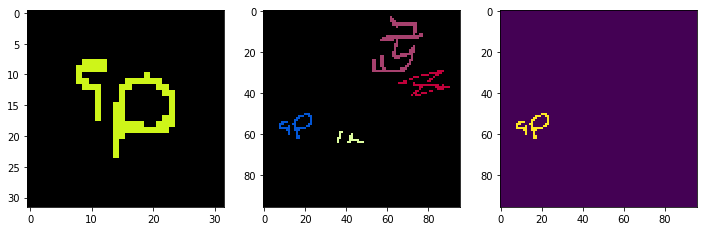

Duration: 6.179012775421143
Hash: b'\xd3\n\xaf%\x03\xdf\x9aP\x8f*\x91\xab\xd1\x9d\x9b\x9e'


In [7]:
#Show some randomly generated example images

# Define number of images
# dataset_size = 5
dataset_size = 2

# Choose training alphabets
chars = chars_train
# Set number of images per parallel job
config.JOBLENGTH = 1
# Set number of distractors
# config.DISTRACTORS = 7
config.DISTRACTORS = 3
# Set dataset split
config.DRAWER_SPLIT = 'train'
config.set_drawer_split()

# set path if images should be saved
dset_dir = DATASET_DIR + '{}_characters/'.format(config.DISTRACTORS + 1)
path = DATASET_DIR + 'visualize/'

# Run visualization
dataset_utils.generate_dataset(path, dataset_size, chars, config, seed=None, save=False, show=True)